# Fooling an MNIST Network: CMA-ME with Constraints in Discrete Behavior Spaces

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/icaros-usc/pyribs/blob/master/examples/tutorials/fooling_mnist.ipynb)

[Nguyen 2015](http://anhnguyen.me/project/fooling/) demonstrated that it is

(brief overview of fooling networks; show some examples)

In [45]:
%pip install ribs torch torchvision tqdm

Note: you may need to restart the kernel to use updated packages.


In [67]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import tqdm

from ribs.archives import GridArchive
from ribs.emitters import GaussianEmitter
from ribs.optimizers import Optimizer

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


# MNIST Network

We'll quickly train a [LeNet-5](https://en.wikipedia.org/wiki/LeNet) to classify MNIST. If you are not familiar with PyTorch, we recommend referring to the [PyTorch 60-minute blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html). Feel free to skip to the next section, where we demonstrate how to fool the network.

First, we'll load the MNIST dataset and preprocess it.

In [4]:
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 1000

MEAN_TRANSFORM = 0.1307
STD_DEV_TRANSFORM = 0.3081

# Transform each image by turning it into a tensor and then
# normalizing the values.
mnist_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((MEAN_TRANSFORM,), (STD_DEV_TRANSFORM,))
])

TRAINLOADER = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data',
                               train=True,
                               download=True,
                               transform=mnist_transforms),
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
)
TESTLOADER = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data',
                               train=False,
                               transform=mnist_transforms),
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
)

This is our training function. We use Cross-Entropy loss and Adam optimization.

In [5]:
def fit(net, epochs):
    criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(net.parameters())

    for epoch in range(epochs):
        print(f"=== Epoch {epoch + 1} ===")
        total_loss = 0.0

        # Iterate through batches in the (shuffled) training dataset.
        for batch_i, data in enumerate(TRAINLOADER):
            inputs = data[0].to(device)
            labels = data[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            if (batch_i + 1) % 100 == 0:
                print(f"Batch {batch_i + 1:5d}: {total_loss}")
                total_loss = 0.0

Now we define the LeNet-5 and train it for 2 epochs.

In [6]:
LENET5 = nn.Sequential(
    nn.Conv2d(1, 6, (5, 5), stride=1, padding=0),  # (1,28,28) -> (6,24,24)
    nn.MaxPool2d(2),  # (6,24,24) -> (6,12,12)
    nn.ReLU(),
    nn.Conv2d(6, 16, (5, 5), stride=1, padding=0),  # (6,12,12) -> (16,8,8)
    nn.MaxPool2d(2),  # (16,8,8) -> (16,4,4)
    nn.ReLU(),
    nn.Flatten(),  # (16,4,4) -> (256,)
    nn.Linear(256, 120),  # (256,) -> (120,)
    nn.ReLU(),
    nn.Linear(120, 84),  # (120,) -> (84,)
    nn.ReLU(),
    nn.Linear(84, 10),  # (84,) -> (10,)
    nn.LogSoftmax(dim=1),  # (10,) output probabilities
).to(device)

fit(LENET5, 2)

=== Epoch 1 ===
Batch   100: 90.05563884973526
Batch   200: 28.76210478693247
Batch   300: 19.684272661805153
Batch   400: 15.75448501482606
Batch   500: 13.357834421098232
Batch   600: 12.08718966320157
Batch   700: 10.556483671069145
Batch   800: 9.339978739619255
Batch   900: 9.977776657789946
=== Epoch 2 ===
Batch   100: 7.4631321877241135
Batch   200: 7.160808344371617
Batch   300: 7.256685642525554
Batch   400: 7.198970447294414
Batch   500: 7.237963899970055
Batch   600: 6.613698286470026
Batch   700: 8.08781830733642
Batch   800: 5.624962490983307
Batch   900: 5.724665587767959


To see how well the network does, we'll evaluate it on the train and test sets.

In [15]:
def evaluate(net, loader):
    correct_per_num = [0 for _ in range(10)]
    total_per_num = [0 for _ in range(10)]

    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.to("cpu"), 1)
            c = (predicted == labels).squeeze()
            for i in range(len(c)):
                label = labels[i]
                correct_per_num[label] += c[i].item()
                total_per_num[label] += 1

    for i in range(10):
        print(f"Correct {i:2d}: {correct_per_num[i] / total_per_num[i]:5.3f}"
              f" ({correct_per_num[i]} / {total_per_num[i]})")
    print(f"TOTAL     : {sum(correct_per_num) / sum(total_per_num):5.3f}"
          f" ({sum(correct_per_num)} / {sum(total_per_num)})")

In [16]:
evaluate(LENET5, TRAINLOADER)

Correct  0: 0.996 (5900 / 5923)
Correct  1: 0.998 (6726 / 6742)
Correct  2: 0.990 (5897 / 5958)
Correct  3: 0.980 (6008 / 6131)
Correct  4: 0.987 (5764 / 5842)
Correct  5: 0.974 (5280 / 5421)
Correct  6: 0.994 (5884 / 5918)
Correct  7: 0.983 (6156 / 6265)
Correct  8: 0.969 (5672 / 5851)
Correct  9: 0.985 (5857 / 5949)
TOTAL     : 0.986 (59144 / 60000)


In [17]:
evaluate(LENET5, TESTLOADER)

Correct  0: 0.994 (974 / 980)
Correct  1: 0.998 (1133 / 1135)
Correct  2: 0.990 (1022 / 1032)
Correct  3: 0.990 (1000 / 1010)
Correct  4: 0.979 (961 / 982)
Correct  5: 0.965 (861 / 892)
Correct  6: 0.987 (946 / 958)
Correct  7: 0.982 (1010 / 1028)
Correct  8: 0.972 (947 / 974)
Correct  9: 0.976 (985 / 1009)
TOTAL     : 0.984 (9839 / 10000)


## Fooling MNIST

Above, we trained a reasonably high-performing network. We will now show how to generate images that make the network believe it is seeing various digits.

TODO: Explain behavior space, objective

In [94]:
img_size = (28, 28)
flat_img_size = 784

archive = GridArchive([10], [(0, 10)])
emitters = [
    GaussianEmitter(np.zeros(flat_img_size), 0.1, archive, batch_size=64)
]
optimizer = Optimizer(archive, emitters)

for i in tqdm.tqdm(range(30_000)):
    sols = optimizer.ask()
    sols = np.clip(sols, -1, 1)

    with torch.no_grad():
        net_input = sols.reshape((-1, 1, *img_size))
        net_input = torch.tensor(net_input, dtype=torch.float32, device=device)
        net_output = LENET5(net_input)
        scores, predicted = torch.max(net_output.to("cpu"), 1)
        scores = torch.exp(scores)
        objs = scores.numpy()
        bcs = predicted.numpy()

    optimizer.tell(objs, bcs)

100%|██████████| 30000/30000 [02:35<00:00, 193.38it/s]


In [95]:
archive.as_pandas()

,index-0,behavior-0,objective,solution-0,solution-1,solution-2,solution-3,solution-4,solution-5,solution-6,...,solution-774,solution-775,solution-776,solution-777,solution-778,solution-779,solution-780,solution-781,solution-782,solution-783
0,8,8.0,0.999994,-1.115009,-0.907968,-4.227008,0.609915,2.746843,3.766778,1.419774,...,2.655139,1.111414,1.432303,-1.219990,-0.459208,3.050352,-0.230894,-2.261601,1.307116,0.765757
1,6,6.0,0.999995,0.990689,0.469256,0.432633,-0.170066,0.847131,1.483720,0.703229,...,-2.447768,0.982460,-0.234436,-0.830460,-0.929451,1.047383,2.511805,-2.034433,2.066612,0.899377
2,5,5.0,0.999997,-2.232336,0.663010,2.886221,-0.239243,0.394504,-1.636266,-3.666874,...,-0.666294,0.212614,0.685936,0.206516,-0.374165,-2.463224,-0.319963,0.478236,2.913427,-0.428216
3,9,9.0,0.999996,-1.528707,-0.113608,-2.724215,-0.164623,0.680227,0.445147,0.993359,...,1.205399,-0.733220,2.361530,0.030937,-0.414414,0.647923,-0.171562,-0.052194,-1.027606,0.513549
4,2,2.0,0.999998,0.724940,2.941073,0.675785,1.901795,0.997574,-0.149194,-1.047320,...,-2.169116,-0.043693,0.158952,1.444307,1.900600,-0.366763,-0.485433,0.673444,1.656865,0.734444
5,3,3.0,0.999998,1.462686,-1.238742,-0.095428,2.942282,1.390643,1.700532,-1.486423,...,3.290092,-1.240908,-0.066389,-2.805334,0.247245,1.352099,0.350120,0.675892,-0.296269,0.226448


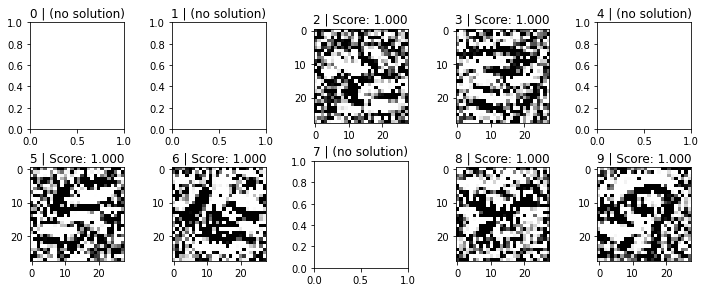

In [96]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
fig.tight_layout()
ax = ax.flatten()
found = set()
for _, row in archive.as_pandas().iterrows():
    i = int(row.loc["index-0"])
    found.add(i)
    obj = row.loc["objective"]
    ax[i].set_title(f"{i} | Score: {obj:.3f}")
    img = row.loc["solution-0":].to_numpy().reshape(28,28)
    img = np.clip(img, -1, 1)
    ax[i].imshow(img, cmap="Greys")
for i in range(10):
    if i not in found:
        ax[i].set_title(f"{i} | (no solution)")